# how many novel lncRNAs are quantified?

evidence that the new lncRNAs are expressed/quantifiable in v10 vs v11.

v10 used gencode 46 with 19000 lncRNAs, v11 uses gencode 47 with 35000 lncRNAs

In [1]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from matplotlib.colors import LogNorm
from scipy import stats
import os

from tqdm.notebook import tqdm

tqdm.pandas()

/local/scratch/klawren/slrmtmp.47792990/ipykernel_21138/889698852.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [2]:
gencode_v39_path = "/home/klawren/oak/gtex/data/other_references/gencode.v39.genes.gtf"
gencode_v47_path = "/home/klawren/oak/gtex/data/realign_references/gencode.v47.genes.gtf"
full_gencode_v39_path = "/home/klawren/oak/gtex/data/other_references/gencode.v39.annotation.gtf"
full_gencode_v47_path = "/home/klawren/oak/gtex/data/realign_references/gencode.v47.annotation.gtf"

v10_quantificaiton_path = "/home/klawren/oak/gtex/data/other_references/v10/gene_tpm_v10_brain_caudate_basal_ganglia.gct.gz"
v11_quantificaiton_dir = "/home/klawren/oak/gtex/output/caudate_analysis"

### comparison of gencode annotations

In [63]:
# load in gencode for lncRNA annotations
gencode_v47=pr.read_gtf(gencode_v47_path).as_df()
gencode_v39=pr.read_gtf(gencode_v39_path).as_df()

In [4]:
full_gencode_v47=pr.read_gtf(full_gencode_v47_path).as_df()
full_gencode_v39=pr.read_gtf(full_gencode_v39_path).as_df()

In [64]:
# drop duplicates (multiple transcripts of same gene) 
gencode_v39 = gencode_v39.drop_duplicates('gene_id')
gencode_v47 = gencode_v47.drop_duplicates('gene_id')

gencode_v47['gene_id_stable'] = gencode_v47['gene_id'].str.split('.').str[0]
gencode_v39['gene_id_stable'] = gencode_v39['gene_id'].str.split('.').str[0]
full_gencode_v39['gene_id_stable'] = full_gencode_v39['gene_id'].str.split('.').str[0]
full_gencode_v47['gene_id_stable'] = full_gencode_v47['gene_id'].str.split('.').str[0]

In [103]:
# harmonize annotation categories as in https://www.gencodegenes.org/pages/biotypes.html
gencode_v39['gene_type_harmonized'] = np.where(gencode_v39['gene_type'].isin(['3prime_overlapping_ncRNA', 'antisense', 'bidirectional_promoter_lncRNA', 'lincRNA', 'macro_lncRNA', 'non_coding', 'processed_transcript', 'sense_intronic','sense_overlapping']), 'lncRNA', gencode_v39['gene_type'])
gencode_v39['gene_type_harmonized'] = np.where(gencode_v39['gene_type_harmonized'].isin(['vaultRNA']), 'vault_RNA', gencode_v39['gene_type_harmonized'])

full_gencode_v39['gene_type_harmonized'] = np.where(full_gencode_v39['gene_type'].isin(['3prime_overlapping_ncRNA', 'antisense', 'bidirectional_promoter_lncRNA', 'lincRNA', 'macro_lncRNA', 'non_coding', 'processed_transcript', 'sense_intronic','sense_overlapping']), 'lncRNA', full_gencode_v39['gene_type'])
full_gencode_v39['gene_type_harmonized'] = np.where(full_gencode_v39['gene_type_harmonized'].isin(['vaultRNA']), 'vault_RNA', full_gencode_v39['gene_type_harmonized'])

In [7]:
gene_type_counts = pd.DataFrame({'v47':gencode_v47.groupby('gene_type').size(), 'v39':gencode_v39.groupby('gene_type_harmonized').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47792990/ipykernel_21138/3796981686.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


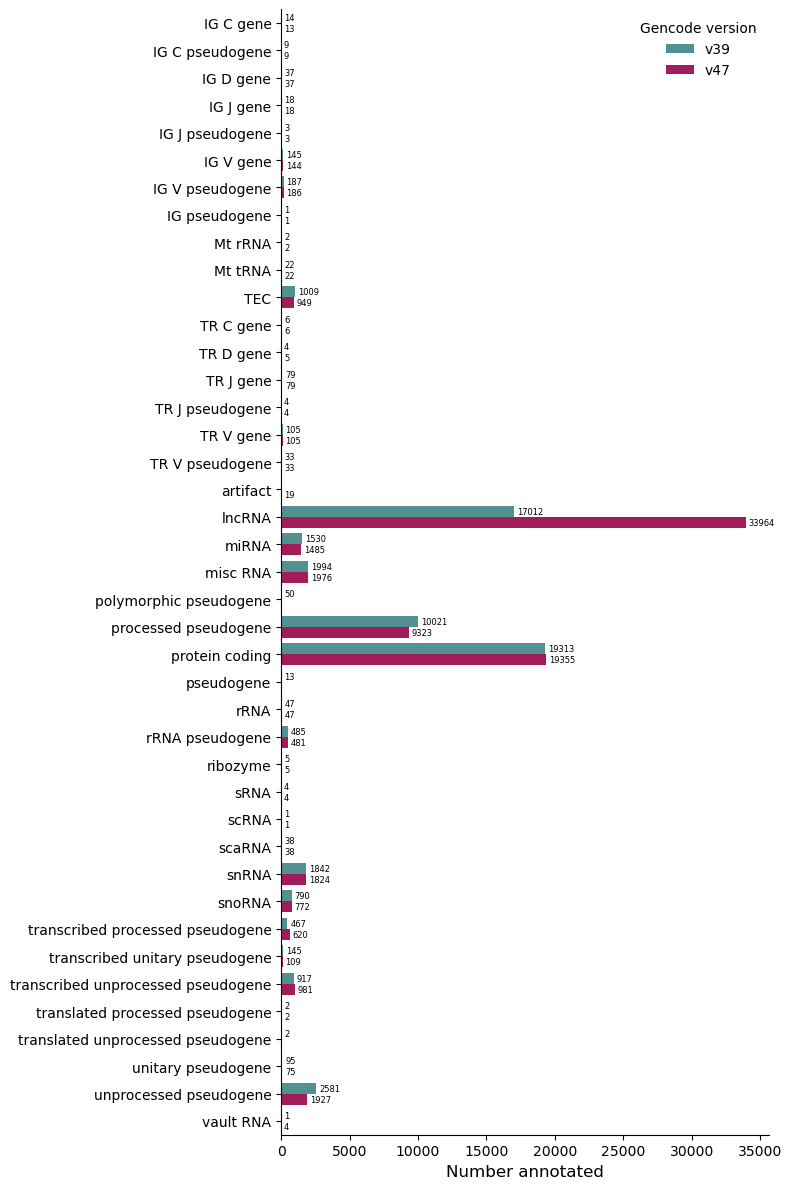

In [8]:
fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=['#4a989c', '#b70657'])

#ax.set_xscale('log')

ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gencode version")

plt.tight_layout() 
plt.show()

In [9]:
# group some categories 
def group_gene_type(gencode_df):
    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['Mt_rRNA',
                                                                                            'Mt_tRNA',
                                                                                            'miRNA',
                                                                                            'misc_RNA',
                                                                                            'rRNA',
                                                                                            'scRNA',
                                                                                            'snRNA',
                                                                                            'snoRNA',
                                                                                            'ribozyme',
                                                                                            'sRNA',
                                                                                            'scaRNA',
                                                                                            'vault_RNA']), 'noncoding_RNA', gencode_df['gene_type_harmonized'])

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['Mt_tRNA_pseudogene',
                                                                                            'tRNA_pseudogene',
                                                                                            'snoRNA_pseudogene',
                                                                                            'snRNA_pseudogene',
                                                                                            'scRNA_pseudogene',
                                                                                            'rRNA_pseudogene',
                                                                                            'misc_RNA_pseudogene',
                                                                                            'miRNA_pseudogene']), 'noncoding_RNA_pseudogene', gencode_df['gene_type_grouped'])
    

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_grouped'].isin(['noncoding_RNA_pseudogene']),'noncoding_RNA', gencode_df['gene_type_grouped'])

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['transcribed_processed_pseudogene',
                                                                                            'transcribed_unprocessed_pseudogene',
                                                                                            'transcribed_unitary_pseudogene',
                                                                                            'translated_processed_pseudogene',
                                                                                            'translated_unprocessed_pseudogene',
                                                                                            'unitary_pseudogene',
                                                                                            'unprocessed_pseudogene',
                                                                                            'pseudogene',
                                                                                            'polymorphic_pseudogene',
                                                                                            'processed_pseudogene',
                                                                                            'IG_C_pseudogene', 
                                                                                            'IG_J_pseudogene', 
                                                                                            'IG_V_pseudogene', 
                                                                                            'IG_pseudogene',
                                                                                            'TR_V_pseudogene',
                                                                                            'TR_J_pseudogene']), 'pseudogene', gencode_df['gene_type_grouped'])
    
    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['protein_coding', 
                                                                                        'TEC',
                                                                                        'IG_C_gene', 
                                                                                        'IG_D_gene', 
                                                                                        'IG_J_gene',
                                                                                        'IG_V_gene', 
                                                                                        'TR_C_gene',
                                                                                        'TR_J_gene',
                                                                                        'TR_V_gene',
                                                                                        'TR_D_gene']), 'protien_coding_or_TEC', gencode_df['gene_type_grouped'])


In [10]:
gencode_v47['gene_type_harmonized'] = gencode_v47['gene_type']
group_gene_type(gencode_v47)
group_gene_type(gencode_v39)

gene_type_counts = pd.DataFrame({'v47':gencode_v47.groupby('gene_type_grouped').size(), 'v39':gencode_v39.groupby('gene_type_grouped').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47792990/ipykernel_21138/3733569505.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


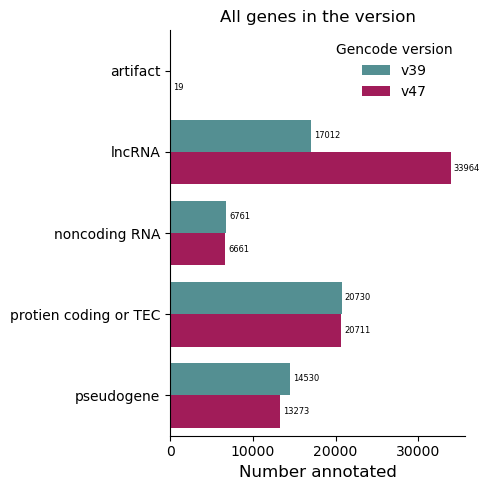

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=[ '#4a989c', '#b70657'])

ax.set_title('All genes in the version')

ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gencode version")

plt.tight_layout() 
plt.show()

In [12]:
print('{} gencode v47 aren\'t in gencode v39'.format(sum(~gencode_v47['gene_id_stable'].isin(gencode_v39['gene_id_stable']))))
print('{} gencode v39 aren\'t in gencode v47'.format(sum(~gencode_v39['gene_id_stable'].isin(gencode_v47['gene_id_stable']))))

18154 gencode v47 aren't in gencode v39
2518 gencode v39 aren't in gencode v47


In [13]:
gene_type_counts = pd.DataFrame({'v47':gencode_v47[~gencode_v47['gene_id_stable'].isin(gencode_v39['gene_id_stable'])].groupby('gene_type_grouped').size(), 'v39':gencode_v39[~gencode_v39['gene_id_stable'].isin(gencode_v47['gene_id_stable'])].groupby('gene_type_grouped').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47792990/ipykernel_21138/3799024315.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


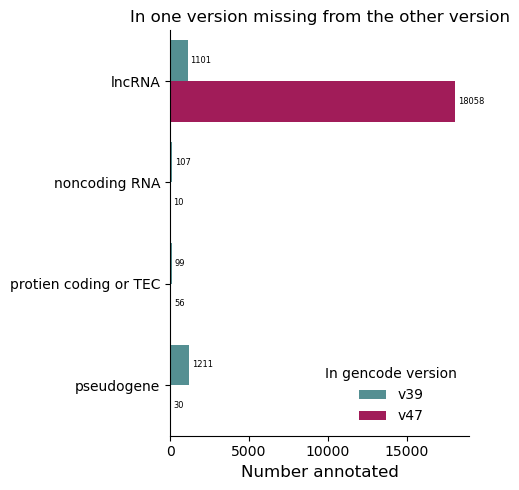

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=[ '#4a989c', '#b70657'])

ax.set_title('In one version missing from the other version')
ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("In gencode version")

plt.tight_layout() 
plt.show()

### investigating v39 ids that aren't in v47

1. v39 gene in v47 and quantified
2. v39 gene in v47 but not quantified due to overlap in v47
3. v39 gene in v47 but as a transcript under a different name(s)
4. part of v39 gene (i.e. transcript, exon) in v47 but as a transcript under a different name(s)

In [15]:
# index v39 by gene id
gid_full_gencode_v39 = full_gencode_v39.set_index('gene_id_stable')

# needs to be done in the full gtf becuase the collapsed gtf changes start/end sites to avoid overlap
full_v39 = gid_full_gencode_v39.loc[gencode_v39['gene_id_stable'].unique()].reset_index()

# add in data from v47 to see if the starts/ends match
v47_location_merged = pd.merge(full_v39, full_gencode_v47[['Chromosome', 'Start', 'End', 'gene_id_stable', 'Feature']], on=['Chromosome', 'Start', 'End'], suffixes=['_v39', '_v47'], how='left')

# group by v39 gene id, see if any of the v47 genes have a matched location 
v47_location_merged_v39_grouped = v47_location_merged.groupby('gene_id_stable_v39').agg({'gene_id_stable_v47':[list, 'unique', 'nunique'], 'Feature_v39':list, 'Feature_v47':list})

# add in flag if the ids match
v47_location_merged_explode = v47_location_merged_v39_grouped.reset_index().explode(('gene_id_stable_v47', 'list'))
v47_location_merged_explode['match'] = v47_location_merged_explode[('gene_id_stable_v47', 'list')] == v47_location_merged_explode['gene_id_stable_v39']
v47_location_merged_id_match = v47_location_merged_explode.groupby('gene_id_stable_v39').agg({('match', ''):'sum'})
v47_location_merged_v39_grouped = v47_location_merged_v39_grouped.join(v47_location_merged_id_match > 0)

In [28]:
# add in match levels
# 1 same id same gene
# 2 different id, match in gene
# 3 different id match in transcript
# 4 different id match in exon

no_id_match = v47_location_merged_v39_grouped[~v47_location_merged_v39_grouped['match']]
v47_location_merged_no_id_match = v47_location_merged[v47_location_merged['gene_id_stable_v39'].isin(no_id_match.index.values)]
v47_location_merged_no_id_match_location_match = v47_location_merged_no_id_match[~v47_location_merged_no_id_match['gene_id_stable_v47'].isna()]
v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v39'] == 'gene']['gene_id_stable_v39'].unique()



# 4 different id match in exon
v47_location_merged_v39_grouped['match_idx_v39'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v39'] == 'exon']['gene_id_stable_v39']),
                                                        4, 0)

# 3 different id match in transcript
v47_location_merged_v39_grouped['match_idx_v39'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v39'] == 'transcript']['gene_id_stable_v39']),
                                                        3, v47_location_merged_v39_grouped['match_idx_v39'])
# 2 different id, match in gene
v47_location_merged_v39_grouped['match_idx_v39'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v39'] == 'gene']['gene_id_stable_v39']),
                                                        2, v47_location_merged_v39_grouped['match_idx_v39'])

# 1 same id same gene
v47_location_merged_v39_grouped['match_idx_v39'] = np.where(v47_location_merged_v39_grouped['match'],
                                                            1, v47_location_merged_v39_grouped['match_idx_v39'])




# 4 different id match in exon
v47_location_merged_v39_grouped['match_idx_v47'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v47'] == 'exon']['gene_id_stable_v39']),
                                                        4, 0)

# 3 different id match in transcript
v47_location_merged_v39_grouped['match_idx_v47'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v47'] == 'transcript']['gene_id_stable_v39']),
                                                        3, v47_location_merged_v39_grouped['match_idx_v47'])
# 2 different id, match in gene
v47_location_merged_v39_grouped['match_idx_v47'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v47'] == 'gene']['gene_id_stable_v39']),
                                                        2, v47_location_merged_v39_grouped['match_idx_v47'])

# 1 same id same gene
v47_location_merged_v39_grouped['match_idx_v47'] = np.where(v47_location_merged_v39_grouped['match'],
                                                            1, v47_location_merged_v39_grouped['match_idx_v47'])


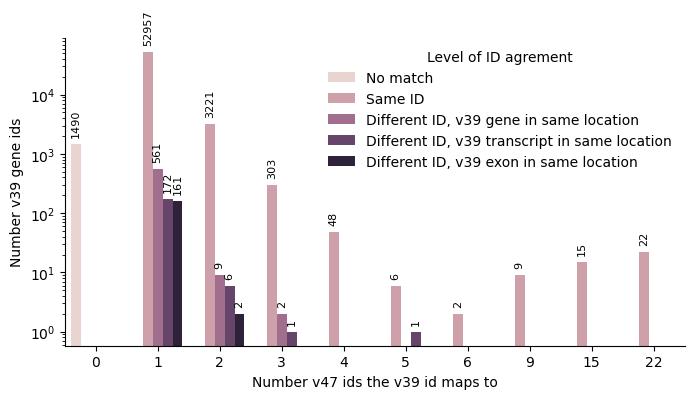

In [29]:
fig, ax = plt.subplots(figsize=(8,4))

sns.countplot(v47_location_merged_v39_grouped, x=('gene_id_stable_v47', 'nunique'), hue='match_idx_v39', ax=ax)
ax.set_yscale('log')
# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=5, fontsize=8, rotation=90)

ax.set_ylabel('Number v39 gene ids')
ax.set_xlabel('Number v47 ids the v39 id maps to')

plt.legend(title='Level of ID agrement', loc='upper right', frameon=False, labels=['No match', 'Same ID', 'Different ID, v39 gene in same location', 'Different ID, v39 transcript in same location', 'Different ID, v39 exon in same location'])

ax.spines[['top', 'right']].set_visible(False)



/local/scratch/klawren/slrmtmp.47792990/ipykernel_21138/888918007.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['No match', 'Same ID', 'Different ID, v47 gene in same location', 'Different ID, v47 transcript in same location', 'Different ID, v47 exon in same location'], rotation=45)


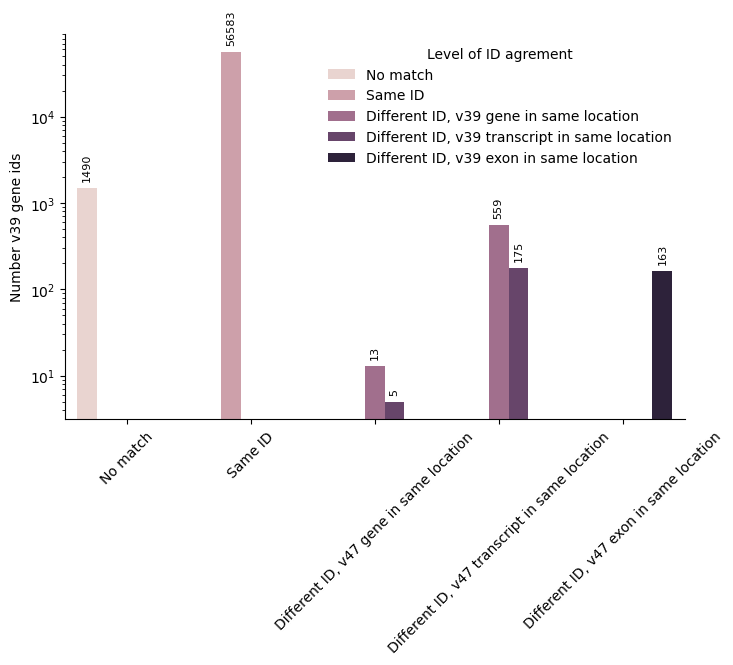

In [30]:
fig, ax = plt.subplots(figsize=(8,5))

sns.countplot(v47_location_merged_v39_grouped, x='match_idx_v47', hue='match_idx_v39', ax=ax)
# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=5, fontsize=8, rotation=90)
ax.set_yscale('log')
ax.spines[['top', 'right']].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Number v39 gene ids')
ax.set_xticklabels(labels=['No match', 'Same ID', 'Different ID, v47 gene in same location', 'Different ID, v47 transcript in same location', 'Different ID, v47 exon in same location'], rotation=45)
plt.legend(title='Level of ID agrement', loc='upper right', frameon=False, labels=['No match', 'Same ID', 'Different ID, v39 gene in same location', 'Different ID, v39 transcript in same location', 'Different ID, v39 exon in same location'])


### and the other way, how many of the v47 are truely not in v39?

In [31]:
# index v47 by gene id
gid_full_gencode_v47 = full_gencode_v47.set_index('gene_id_stable')

# needs to be done in the full gtf becuase the collapsed gtf changes start/end sites to avoid overlap
full_v47 = gid_full_gencode_v47.loc[gencode_v47['gene_id_stable'].unique()].reset_index()

# add in data from v47 to see if the starts/ends match
v39_location_merged = pd.merge(full_v47, full_gencode_v39[['Chromosome', 'Start', 'End', 'gene_id_stable', 'Feature']], on=['Chromosome', 'Start', 'End'], suffixes=['_v47', '_v39'], how='left')

# group by v39 gene id, see if any of the v47 genes have a matched location 
v39_location_merged_v47_grouped = v39_location_merged.groupby('gene_id_stable_v47').agg({'gene_id_stable_v39':[list, 'unique', 'nunique'], 'Feature_v39':list, 'Feature_v47':list})

# add in flag if the ids match
v39_location_merged_explode = v39_location_merged_v47_grouped.reset_index().explode(('gene_id_stable_v39', 'list'))
v39_location_merged_explode['match'] = v39_location_merged_explode[('gene_id_stable_v39', 'list')] == v39_location_merged_explode['gene_id_stable_v47']
v39_location_merged_id_match = v39_location_merged_explode.groupby('gene_id_stable_v47').agg({('match', ''):'sum'})
v39_location_merged_v47_grouped = v39_location_merged_v47_grouped.join(v39_location_merged_id_match > 0)

In [32]:
# add in match levels
# 1 same id same gene
# 2 different id, match in gene
# 3 different id match in transcript
# 4 different id match in exon

no_id_match = v39_location_merged_v47_grouped[~v39_location_merged_v47_grouped['match']]
v39_location_merged_no_id_match = v39_location_merged[v39_location_merged['gene_id_stable_v47'].isin(no_id_match.index.values)]
v39_location_merged_no_id_match_location_match = v39_location_merged_no_id_match[~v39_location_merged_no_id_match['gene_id_stable_v39'].isna()]
v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v47'] == 'gene']['gene_id_stable_v47'].unique()

# 1 same id same gene
v39_location_merged_v47_grouped['match_idx_v39'] = np.where(v39_location_merged_v47_grouped['match'], 1, 0)

# 4 different id match in exon
v39_location_merged_v47_grouped['match_idx_v39'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v39'] == 'exon']['gene_id_stable_v47']),
                                                        4, v39_location_merged_v47_grouped['match_idx_v39'])

# 3 different id match in transcript
v39_location_merged_v47_grouped['match_idx_v39'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v39'] == 'transcript']['gene_id_stable_v47']),
                                                        3, v39_location_merged_v47_grouped['match_idx_v39'])
# 2 different id, match in gene
v39_location_merged_v47_grouped['match_idx_v39'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v39'] == 'gene']['gene_id_stable_v47']),
                                                        2, v39_location_merged_v47_grouped['match_idx_v39'])



# 1 same id same gene
v39_location_merged_v47_grouped['match_idx_v47'] = np.where(v39_location_merged_v47_grouped['match'], 1, 0)

# 4 different id match in exon
v39_location_merged_v47_grouped['match_idx_v47'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v47'] == 'exon']['gene_id_stable_v47']),
                                                        4, v39_location_merged_v47_grouped['match_idx_v47'])

# 3 different id match in transcript
v39_location_merged_v47_grouped['match_idx_v47'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v47'] == 'transcript']['gene_id_stable_v47']),
                                                        3, v39_location_merged_v47_grouped['match_idx_v47'])
# 2 different id, match in gene
v39_location_merged_v47_grouped['match_idx_v47'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v47'] == 'gene']['gene_id_stable_v47']),
                                                        2, v39_location_merged_v47_grouped['match_idx_v47'])



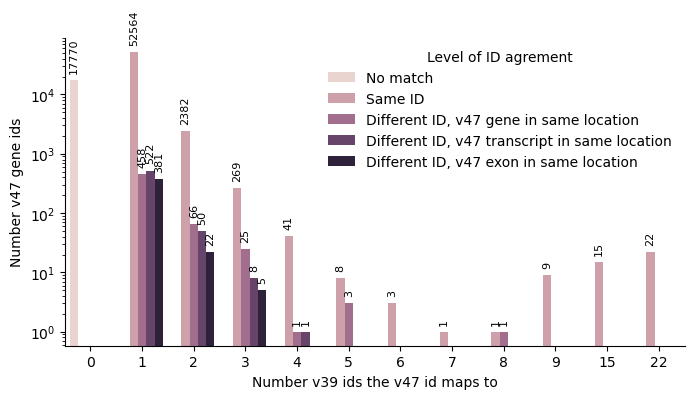

In [33]:
fig, ax = plt.subplots(figsize=(8,4))

sns.countplot(v39_location_merged_v47_grouped, x=('gene_id_stable_v39', 'nunique'), hue='match_idx_v39', ax=ax)
ax.set_yscale('log')
# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=5, fontsize=8, rotation=90)

ax.set_ylabel('Number v47 gene ids')
ax.set_xlabel('Number v39 ids the v47 id maps to')

plt.legend(title='Level of ID agrement', loc='upper right', frameon=False, labels=['No match', 'Same ID', 'Different ID, v47 gene in same location', 'Different ID, v47 transcript in same location', 'Different ID, v47 exon in same location'])

ax.spines[['top', 'right']].set_visible(False)



/local/scratch/klawren/slrmtmp.47792990/ipykernel_21138/3733613344.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['No match', 'Same ID', 'Different ID, v39 gene in same location', 'Different ID, v39 transcript in same location', 'Different ID, v39 exon in same location'], rotation=45)


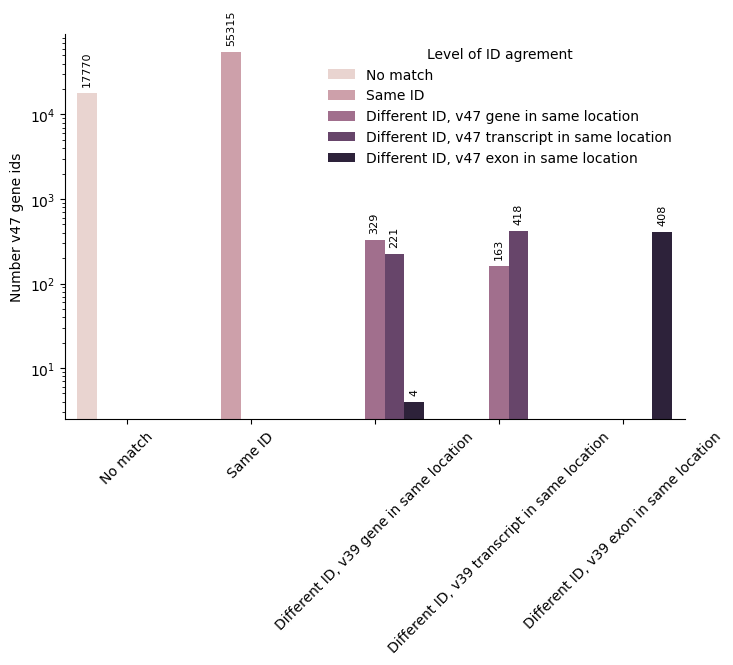

In [34]:
fig, ax = plt.subplots(figsize=(8,5))

sns.countplot(v39_location_merged_v47_grouped, x='match_idx_v39', hue='match_idx_v47', ax=ax)
# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=5, fontsize=8, rotation=90)
ax.set_yscale('log')
ax.spines[['top', 'right']].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Number v47 gene ids')
ax.set_xticklabels(labels=['No match', 'Same ID', 'Different ID, v39 gene in same location', 'Different ID, v39 transcript in same location', 'Different ID, v39 exon in same location'], rotation=45)
plt.legend(title='Level of ID agrement', loc='upper right', frameon=False, labels=['No match', 'Same ID', 'Different ID, v47 gene in same location', 'Different ID, v47 transcript in same location', 'Different ID, v47 exon in same location'])


In [38]:
full_gencode_v39[full_gencode_v39['gene_id_stable'] == v39_location_merged_v47_grouped[v39_location_merged_v47_grouped[('gene_id_stable_v39', 'nunique')] > 20].index.values[0]]


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid,gene_id_stable
941789,chr5,HAVANA,gene,141338759,141512975,.,+,.,ENSG00000081853.15,protein_coding,...,NaN,NaN,overlapping_locus,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000081853
941790,chr5,HAVANA,transcript,141338759,141343302,.,+,.,ENSG00000081853.15,protein_coding,...,PCDHGA2-202,NA,basic,OTTHUMT00000377024.2,NaN,NaN,NaN,ENSP00000483020.1,NaN,ENSG00000081853
941791,chr5,HAVANA,exon,141338759,141343302,.,+,.,ENSG00000081853.15,protein_coding,...,PCDHGA2-202,NA,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853
941792,chr5,HAVANA,CDS,141338971,141341440,.,+,0,ENSG00000081853.15,protein_coding,...,PCDHGA2-202,NA,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853
941793,chr5,HAVANA,start_codon,141338971,141338974,.,+,0,ENSG00000081853.15,protein_coding,...,PCDHGA2-202,NA,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853
941794,chr5,HAVANA,stop_codon,141341440,141341443,.,+,0,ENSG00000081853.15,protein_coding,...,PCDHGA2-202,NA,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853
941795,chr5,HAVANA,UTR,141338759,141338971,.,+,.,ENSG00000081853.15,protein_coding,...,PCDHGA2-202,NA,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853
941796,chr5,HAVANA,UTR,141341440,141343302,.,+,.,ENSG00000081853.15,protein_coding,...,PCDHGA2-202,NA,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853
941797,chr5,HAVANA,transcript,141338759,141512975,.,+,.,ENSG00000081853.15,protein_coding,...,PCDHGA2-201,1,CCDS,OTTHUMT00000374738.2,NaN,NaN,NaN,ENSP00000378077.2,CCDS47289.1,ENSG00000081853
941798,chr5,HAVANA,exon,141338759,141341395,.,+,.,ENSG00000081853.15,protein_coding,...,PCDHGA2-201,1,CCDS,OTTHUMT00000374738.2,1,ENSE00001161295.7,NaN,ENSP00000378077.2,CCDS47289.1,ENSG00000081853


### output with summaries of how gene ids are shared

* full_match
* partial_match (match at gene/transcript/exon level)
* v39_only (no match even at exon level)
* v47_only (no match even at exon level)

and then another column for if its quantified in v39 and v47 or not due to overlap
* in collapsed v39
* in collaped v47

In [106]:
# get list of all gene ids in either
id_mapping = pd.merge(full_gencode_v39.drop_duplicates(['gene_id', 'gene_id_stable'])[['gene_id', 'gene_id_stable', 'gene_type_harmonized']], full_gencode_v47.drop_duplicates(['gene_id', 'gene_id_stable'])[['gene_id', 'gene_id_stable', 'gene_type']], on='gene_id_stable', suffixes=['_v39', '_v47'], how='outer')
id_mapping

,gene_id_v39,gene_id_stable,gene_type_harmonized,gene_id_v47,gene_type
0,ENSG00000223972.5,ENSG00000223972,transcribed_unprocessed_pseudogene,ENSG00000223972.6,transcribed_unprocessed_pseudogene
1,ENSG00000243485.5,ENSG00000243485,lncRNA,ENSG00000243485.6,lncRNA
2,ENSG00000284332.1,ENSG00000284332,miRNA,ENSG00000284332.1,miRNA
3,ENSG00000268020.3,ENSG00000268020,unprocessed_pseudogene,ENSG00000268020.3,transcribed_unprocessed_pseudogene
4,ENSG00000240361.2,ENSG00000240361,transcribed_unprocessed_pseudogene,ENSG00000240361.3,transcribed_unprocessed_pseudogene
...,...,...,...,...,...
79991,NaN,ENSG00000292367,NaN,ENSG00000292367.1,processed_pseudogene
79992,NaN,ENSG00000292368,NaN,ENSG00000292368.1,processed_pseudogene
79993,NaN,ENSG00000292370,NaN,ENSG00000292370.2,lncRNA
79994,NaN,ENSG00000310542,NaN,ENSG00000310542.1,lncRNA


In [107]:
id_mapping['in_collapsed_v39'] = id_mapping['gene_id_v39'].isin(gencode_v39['gene_id'])
id_mapping['in_collapsed_v47'] = id_mapping['gene_id_v47'].isin(gencode_v47['gene_id'])

In [113]:
id_mapping['match_level'] = 'partial_match'
id_mapping['match_level'] = np.where(~(id_mapping['gene_id_v39'].isna()) & ~(id_mapping['gene_id_v47'].isna()), 
                                     'full_match', id_mapping['match_level'])

unique_v47_ids = v39_location_merged_v47_grouped[v39_location_merged_v47_grouped[('gene_id_stable_v39', 'nunique')]==0].index.values
id_mapping.loc[id_mapping['gene_id_stable'].isin(unique_v47_ids),'match_level'] = 'unique_v47'


unique_v39_ids = v47_location_merged_v39_grouped[v47_location_merged_v39_grouped[('gene_id_stable_v47', 'nunique')]==0].index.values
id_mapping.loc[id_mapping['gene_id_stable'].isin(unique_v39_ids),'match_level'] = 'unique_v39'

id_mapping['gene_type'] = np.where(id_mapping['gene_type'].isna(), id_mapping['gene_type_harmonized'], id_mapping['gene_type'])
id_mapping = id_mapping.drop(columns='gene_type_harmonized')


In [115]:
id_mapping.to_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', index=None, sep='\t')